### Import libraries

In [2]:
import pandas as pd
import numpy as np

import os
from imutils import paths

import matplotlib.pyplot as plt
import seaborn as sns

import cv2

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

import keras
import keras_tuner as kt
from kerastuner.tuners import RandomSearch
from keras.regularizers import l2

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

C:\Users\acer\AppData\Local\Temp\ipykernel_98632\1886964536.py:10: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [4]:
dataset_path = "DB_corals"

In [5]:
# Ambil semua path gambar dalam dataset
imagePaths = list(paths.list_images(dataset_path))

data = []
labels = []


In [6]:
for imagePath in imagePaths:
    # Ambil nama folder sebagai label (bleached atau healthy)
    label = os.path.basename(os.path.dirname(imagePath))

    # Baca gambar dengan OpenCV
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))  # Ubah ukuran agar sesuai dengan input model

    # Simpan dalam list
    data.append(image)
    labels.append(label)


In [7]:
set(labels)

{'bleached', 'healthy'}

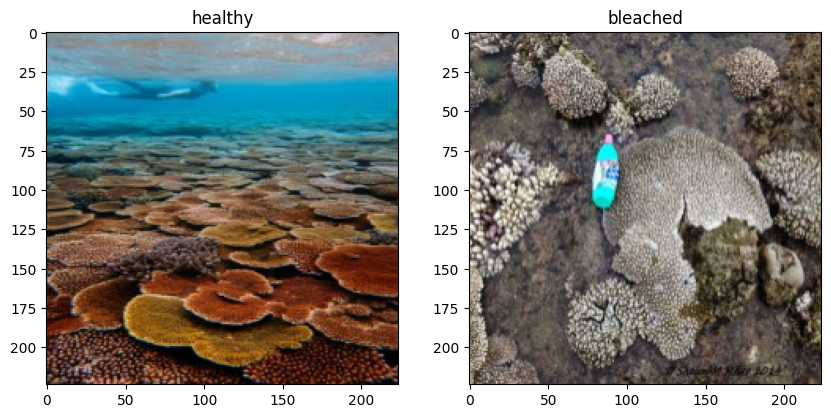

In [20]:
plt.figure(figsize=(10,10))

plt.subplot(1,2,1)
plt.imshow(data[500])
plt.title(labels[500])

plt.subplot(1,2,2)
plt.imshow(data[25])
plt.title(labels[25])

plt.show()


In [8]:
X_train_full, X_test, y_train_full, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full,test_size=0.1, random_state=42)

### Normalization

In [9]:
X_train = np.array(X_train) / 255.0
X_valid = np.array(X_valid) / 255.0
X_test = np.array(X_test) / 255.0

In [10]:
y_train = np.array([1 if label == 'healthy' else 0 for label in y_train])
y_valid = np.array([1 if label == 'healthy' else 0 for label in y_valid])
y_test = np.array([1 if label == 'healthy' else 0 for label in y_test])

### Training


In [11]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [12]:
model_1 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

C:\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [14]:
history = model_1.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.5504 - loss: 0.9729 - val_accuracy: 0.6892 - val_loss: 0.6321
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - accuracy: 0.6704 - loss: 0.5994 - val_accuracy: 0.6892 - val_loss: 0.5585
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.7165 - loss: 0.5442 - val_accuracy: 0.7162 - val_loss: 0.5831
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.7219 - loss: 0.5094 - val_accuracy: 0.7162 - val_loss: 0.5966
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.7551 - loss: 0.4696 - val_accuracy: 0.7027 - val_loss: 0.6062
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.7874 - loss: 0.4609 - val_accuracy: 0.7027 - val_loss: 0.5949
Epoch 7/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.8053 - loss: 0.4029 - val_accuracy: 0.6892 - val_loss: 0.6279
Epoch 8/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.8169 - loss: 0.3731 - val_accuracy: 0.7162 - val_loss:

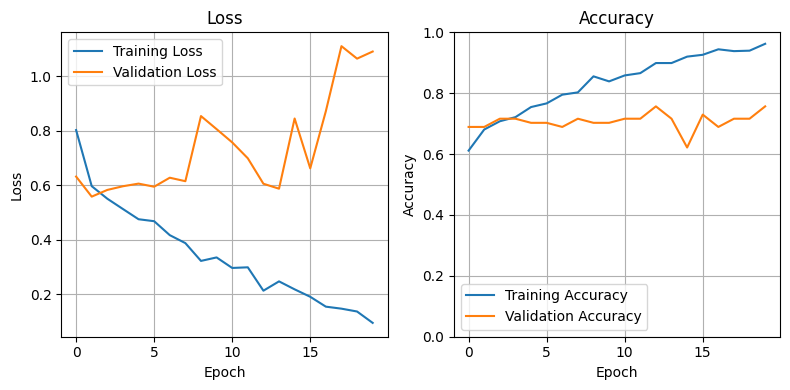

In [15]:
fig, axs = plt.subplots(1,2, figsize=(8, 4))

axs[0].plot(history.history['loss'], label='Training Loss')
axs[0].plot(history.history['val_loss'], label='Validation Loss')
axs[0].set_title('Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(history.history['accuracy'], label='Training Accuracy')
axs[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[1].set_title('Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim(0, 1)
axs[1].legend()
axs[1].grid(True)


plt.tight_layout()
plt.show()

In [16]:
y_pred = model_1.predict(X_test)
y_pred = np.round(y_pred)
target_names = ['healthy', 'bleached']

report = classification_report(y_test, y_pred, output_dict=True, target_names=target_names)
df = pd.DataFrame(report).transpose()
df

6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 520ms/step


,precision,recall,f1-score,support
healthy,0.774194,0.705882,0.738462,102.000000
bleached,0.673913,0.746988,0.708571,83.000000
accuracy,0.724324,0.724324,0.724324,0.724324
macro avg,0.724053,0.726435,0.723516,185.000000
weighted avg,0.729203,0.724324,0.725051,185.000000


In [17]:
model_1.save('model_corals.keras')

### Data Augmentation

In [16]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [17]:
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow(X_train, y_train, batch_size=32)




In [18]:
model_2 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [21]:
model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [22]:
history_2 = model_2.fit(train_generator, epochs=20, validation_data=(X_valid, y_valid))

C:\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.5418 - loss: 1.1320 - val_accuracy: 0.6892 - val_loss: 0.5909
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.6558 - loss: 0.6238 - val_accuracy: 0.7162 - val_loss: 0.5808
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.7132 - loss: 0.5687 - val_accuracy: 0.6892 - val_loss: 0.5789
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.7101 - loss: 0.5475 - val_accuracy: 0.6757 - val_loss: 0.5423
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.7042 - loss: 0.5691 - val_accuracy: 0.7027 - val_loss: 0.5593
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.7022 - loss: 0.5381 - val_accuracy: 0.7027 - val_loss: 0.5410
Epoch 7/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.7245 - loss: 0.5393 - val_accuracy: 0.7162 - val_loss: 0.5295
Epoch 8/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.7437 - loss: 0.5034 - val_accuracy: 0.7027 - val_loss:

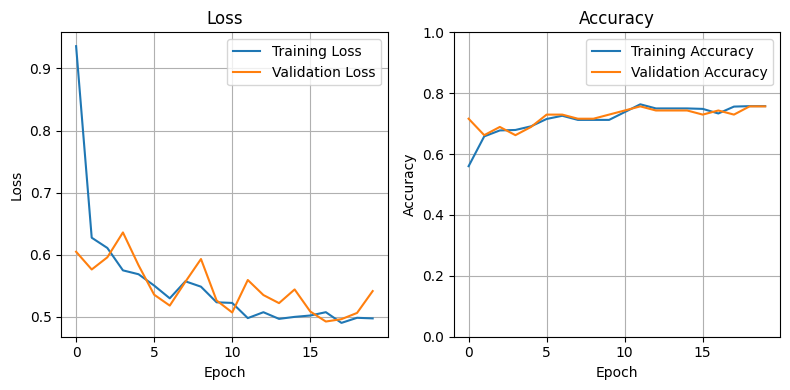

In [57]:
fig, axs = plt.subplots(1,2, figsize=(8, 4))

axs[0].plot(history_2.history['loss'], label='Training Loss')
axs[0].plot(history_2.history['val_loss'], label='Validation Loss')
axs[0].set_title('Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(history_2.history['accuracy'], label='Training Accuracy')
axs[1].plot(history_2.history['val_accuracy'], label='Validation Accuracy')
axs[1].set_title('Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim(0, 1)
axs[1].legend()
axs[1].grid(True)


plt.tight_layout()
plt.show()

In [25]:
y_pred = model_2.predict(X_test)
y_pred = np.round(y_pred)
target_names = ['healthy', 'bleached']

report = classification_report(y_test, y_pred, output_dict=True, target_names=target_names)
df = pd.DataFrame(report).transpose()
df

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 513ms/step


,precision,recall,f1-score,support
healthy,0.782609,0.705882,0.742268,102.00000
bleached,0.677419,0.759036,0.715909,83.00000
accuracy,0.729730,0.729730,0.729730,0.72973
macro avg,0.730014,0.732459,0.729089,185.00000
weighted avg,0.735416,0.729730,0.730442,185.00000


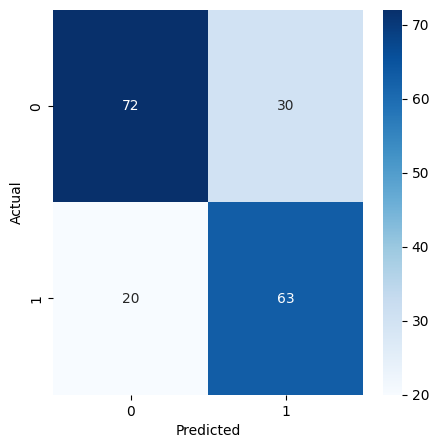

In [26]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### RandomSearch

In [36]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [98]:
def build_model(hp):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(Conv2D(hp.Int(f'conv_{i}_units', 32, 128, step=32), (3, 3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(hp.Int('dense_units', 64, 256, step=32), activation='relu'))
    model.add(Dropout(hp.Float('dropout', 0, 0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
                  loss='binary_crossentropy',
                  metrics=keras.metrics.MeanSquaredError())
    return model


In [99]:
tuner = RandomSearch(
    build_model,
    objective='val_mean_squared_error',
    max_trials=10,
    executions_per_trial=3,
    directory='my_dir',
    project_name='corals_tuning'
)

In [100]:
# Perform the search
tuner.search(X_train, y_train, epochs=10,
             validation_data=(X_valid, y_valid),
             callbacks=[keras.callbacks.EarlyStopping(patience=5)])

# Get the best hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best hyperparameters: {best_hps}")

# Build the model with the best hyperparameters and train it on the data
model_3 = tuner.hypermodel.build(best_hps)
history_3 = model_3.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))


Trial 10 Complete [00h 04m 45s]
val_mean_squared_error: 0.25011228521664935

Best val_mean_squared_error So Far: 0.17068410416444144
Total elapsed time: 01h 13m 22s
Best hyperparameters: <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x000002921F4E0850>
Epoch 1/10
21/21 [==============================] - 10s 435ms/step - loss: 0.6565 - mean_squared_error: 0.2311 - val_loss: 0.5947 - val_mean_squared_error: 0.2050
Epoch 2/10
21/21 [==============================] - 9s 418ms/step - loss: 0.5361 - mean_squared_error: 0.1817 - val_loss: 0.5463 - val_mean_squared_error: 0.1836
Epoch 3/10
21/21 [==============================] - 9s 423ms/step - loss: 0.4717 - mean_squared_error: 0.1562 - val_loss: 0.5680 - val_mean_squared_error: 0.1883
Epoch 4/10
21/21 [==============================] - 9s 419ms/step - loss: 0.4568 - mean_squared_error: 0.1499 - val_loss: 0.7597 - val_mean_squared_error: 0.2421
Epoch 5/10
21/21 [==============================] - 9s 423ms/s

In [108]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print all hyperparameters and their values
print("Best hyperparameters:")
for hp_name, hp_value in best_hps.values.items():
    print(f"{hp_name}: {hp_value}")

Best hyperparameters:
num_layers: 1
conv_0_units: 64
dense_units: 96
dropout: 0.0
learning_rate: 0.0001
conv_1_units: 128
conv_2_units: 96


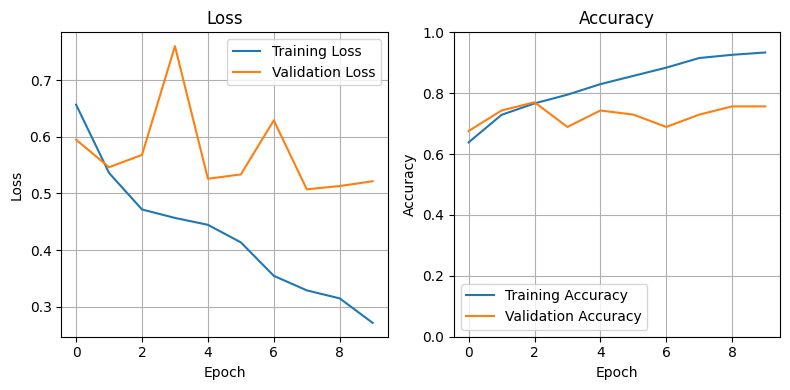

In [101]:
fig, axs = plt.subplots(1,2, figsize=(8, 4))

axs[0].plot(history_3.history['loss'], label='Training Loss')
axs[0].plot(history_3.history['val_loss'], label='Validation Loss')
axs[0].set_title('Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(history.history['accuracy'], label='Training Accuracy')
axs[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[1].set_title('Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim(0, 1)
axs[1].legend()
axs[1].grid(True)


plt.tight_layout()
plt.show()

In [102]:
y_pred = model_3.predict(X_test)
y_pred = np.round(y_pred)
target_names = ['healthy_corals', 'bleached_corals']

report = classification_report(y_test, y_pred, output_dict=True, target_names=target_names)
df = pd.DataFrame(report).transpose()
df

6/6 [==============================] - 1s 96ms/step


,precision,recall,f1-score,support
healthy_corals,0.839080,0.715686,0.772487,102.000000
bleached_corals,0.704082,0.831325,0.762431,83.000000
accuracy,0.767568,0.767568,0.767568,0.767568
macro avg,0.771581,0.773506,0.767459,185.000000
weighted avg,0.778513,0.767568,0.767975,185.000000


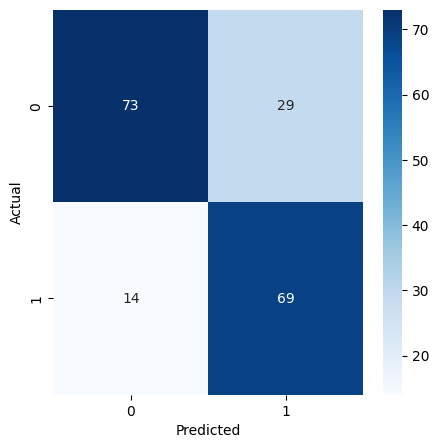

In [103]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Augmentation and Early Stopping ###


In [27]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [28]:
model_4 = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(96, activation='relu'),
    Dropout(0.0),
    Dense(1, activation='sigmoid')
])

model_4.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

C:\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [29]:
# use augmented
history_4 = model_4.fit(train_generator, epochs=20, validation_data=(X_valid, y_valid), callbacks=[EarlyStopping(patience=5)])

Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 150s 7s/step - accuracy: 0.4856 - loss: 0.8739 - val_accuracy: 0.7297 - val_loss: 0.6258
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 113s 5s/step - accuracy: 0.7095 - loss: 0.6222 - val_accuracy: 0.6351 - val_loss: 0.5741
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 117s 6s/step - accuracy: 0.7105 - loss: 0.5613 - val_accuracy: 0.6757 - val_loss: 0.6005
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 143s 7s/step - accuracy: 0.6826 - loss: 0.5617 - val_accuracy: 0.7432 - val_loss: 0.5151
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 122s 6s/step - accuracy: 0.6987 - loss: 0.5458 - val_accuracy: 0.7027 - val_loss: 0.5154
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 157s 6s/step - accuracy: 0.7458 - loss: 0.5331 - val_accuracy: 0.7027 - val_loss: 0.5065
Epoch 7/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 124s 6s/step - accuracy: 0.7166 - loss: 0.5273 - val_accuracy: 0.7297 - val_loss: 0.5124
Epoch 8/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 139s 7s/step - accuracy: 0.7088 - loss: 0.5550 - val_accuracy: 0.7297 - v

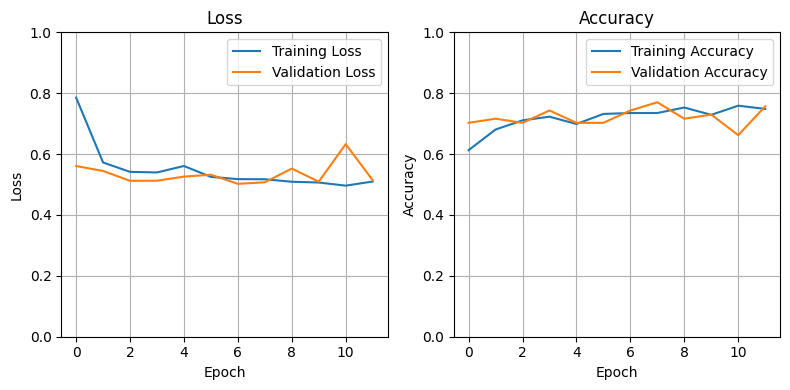

In [47]:
fig, axs = plt.subplots(1,2, figsize=(8, 4))

axs[0].plot(history_4.history['loss'], label='Training Loss')
axs[0].plot(history_4.history['val_loss'], label='Validation Loss')
axs[0].set_title('Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_ylim(0, 1)
axs[0].legend()
axs[0].grid(True)

axs[1].plot(history_4.history['accuracy'], label='Training Accuracy')
axs[1].plot(history_4.history['val_accuracy'], label='Validation Accuracy')
axs[1].set_title('Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim(0, 1)
axs[1].legend()
axs[1].grid(True)


plt.tight_layout()
plt.show()

In [48]:
y_pred = model_4.predict(X_test)
y_pred = np.round(y_pred)
target_names = ['healthy_corals', 'bleached_corals']

report = classification_report(y_test, y_pred, output_dict=True, target_names=target_names)
df = pd.DataFrame(report).transpose()
df

6/6 [==============================] - 2s 293ms/step


,precision,recall,f1-score,support
healthy_corals,0.853933,0.745098,0.795812,102.000000
bleached_corals,0.729167,0.843373,0.782123,83.000000
accuracy,0.789189,0.789189,0.789189,0.789189
macro avg,0.791550,0.794236,0.788967,185.000000
weighted avg,0.797957,0.789189,0.789670,185.000000


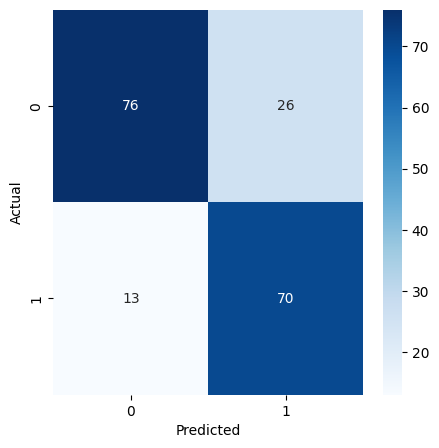

In [49]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Save the model

In [50]:
model_4.save('model_corals.keras')

In [1]:
import tensorflow_model_optimization as tfmot

# Load model
model = tf.keras.models.load_model("model_corals.keras")

# Pruning pada seluruh layer
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
pruned_model = prune_low_magnitude(model)

# Simpan ulang model
pruned_model.save("model_corals_pruned.keras", include_optimizer=False)

print("Model berhasil dikompresi!")

ImportError: Keras cannot be imported. Check that it is installed.